🔍 Testing Normality of Serial Recall Memory Data
📊 Loaded 326 trials
📋 Conditions: {'chunking': 82, 'tapping': 82, 'normal': 81, 'suppression': 81}

📈 Overall Serial Recall Accuracy Statistics:
Mean: 0.789
Std:  0.236
Min:  0.143
Max:  1.000

🧪 NORMALITY TESTS (Overall Serial Recall Accuracy)
Shapiro-Wilk Test:
  Statistic: 0.8203, p-value: 0.000000
  Normal? No (α=0.05)

D'Agostino's Test:
  Statistic: 32.2082, p-value: 0.000000
  Normal? No (α=0.05)

Jarque-Bera Test:
  Statistic: 35.3024, p-value: 0.000000
  Normal? No (α=0.05)

🔬 NORMALITY BY CONDITION
Chunking     (n=82): mean=0.922, p=0.0000, Normal: No
Normal       (n=81): mean=0.771, p=0.0000, Normal: No
Suppression  (n=81): mean=0.616, p=0.0002, Normal: No
Tapping      (n=82): mean=0.845, p=0.0000, Normal: No


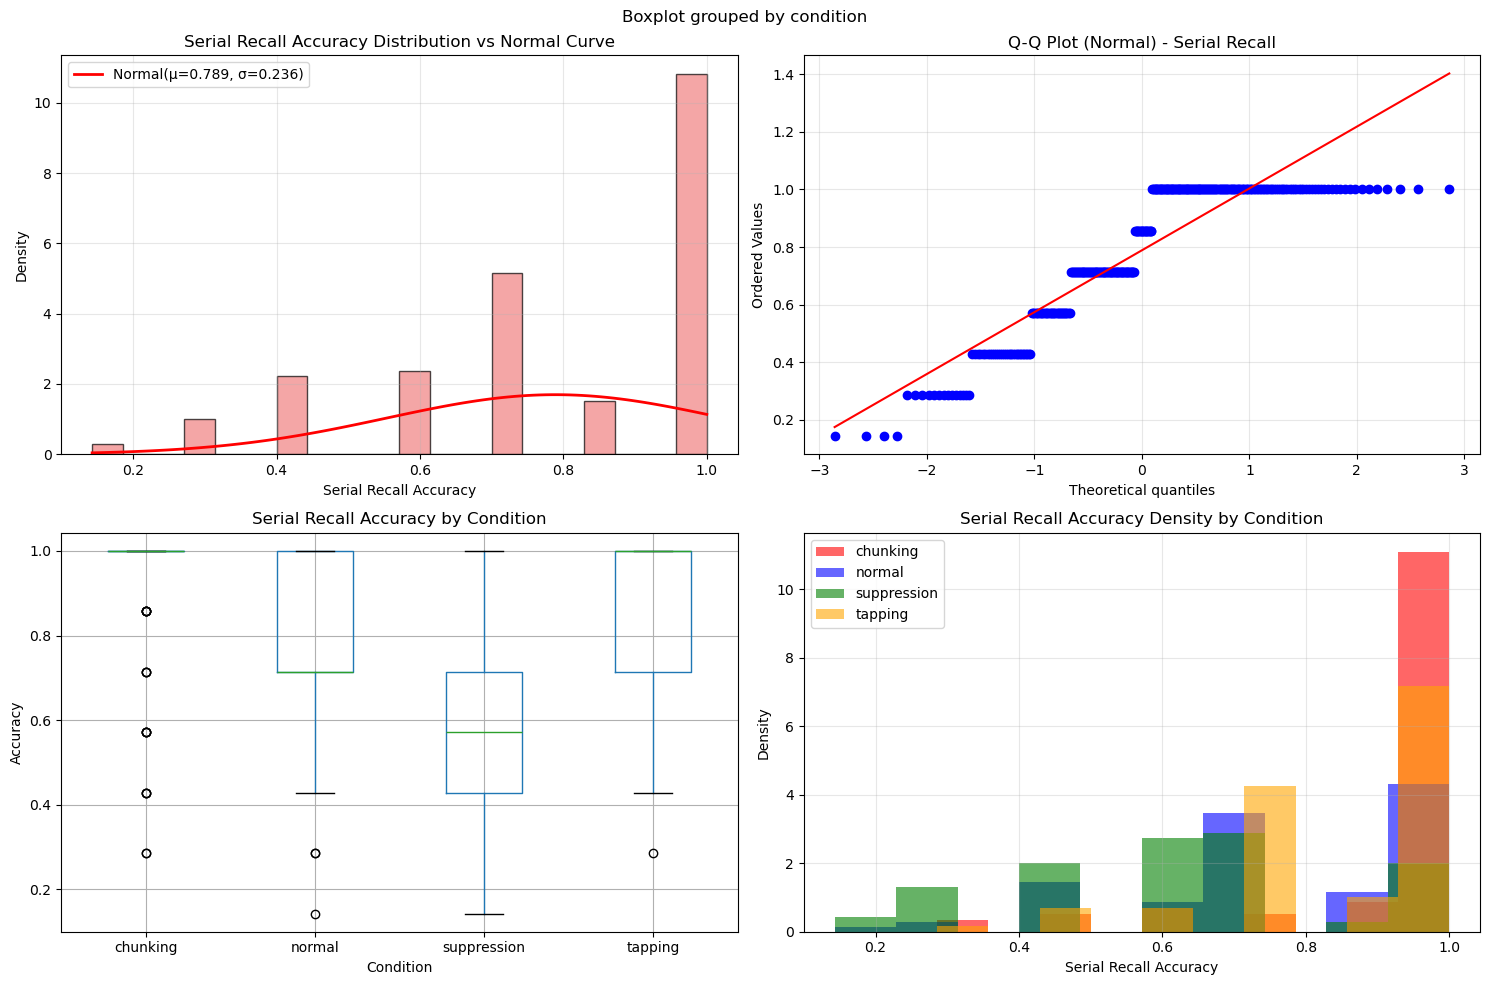


📋 SUMMARY & RECOMMENDATIONS - SERIAL RECALL
❌ Overall data is NOT normally distributed
   → Non-parametric tests (Mann-Whitney, Kruskal-Wallis) recommended
❌ Most conditions (4/4) are NOT normal
   → Use non-parametric tests (Kruskal-Wallis)

💡 NEXT STEPS FOR SERIAL RECALL:
   • Try log transformation: log(accuracy + 0.001)
   • Try square root transformation: sqrt(accuracy)
   • Use non-parametric alternatives

🧠 SERIAL RECALL SPECIFIC NOTES:
   • Position-specific accuracy calculated (exact sequence matching)
   • 7-letter sequences instead of 15-word lists
   • Conditions: chunking, normal, suppression, tapping
   • Tests working memory subsystems (phonological loop, visuospatial sketchpad)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, kstest, jarque_bera
import seaborn as sns
import os

# Load data
filepath = os.getcwd()
results_filepath = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','serial_recall_results_cleaned.csv'))

print("🔍 Testing Normality of Serial Recall Memory Data")
print("="*50)

# Read and clean data (adapted for serial recall)
def clean_letter_list(val):
    """Parse letter lists from the Python list format"""
    try:
        import ast
        return [letter.strip().lower() for letter in ast.literal_eval(str(val))]
    except:
        return []

def calculate_serial_accuracy(presented, recalled):
    """Calculate accuracy for serial recall (position-specific)"""
    if len(presented) != 7 or not recalled:
        return 0
    
    presented_clean = [letter.strip().lower() for letter in presented]
    recalled_clean = [letter.strip().lower() for letter in recalled]
    
    # Pad recalled list if shorter than presented
    while len(recalled_clean) < len(presented_clean):
        recalled_clean.append('')
    
    # Calculate position-specific accuracy
    correct_positions = sum(1 for i in range(len(presented_clean)) 
                          if i < len(recalled_clean) and presented_clean[i] == recalled_clean[i])
    return correct_positions / 7

# Load and process data
df = pd.read_csv(results_filepath)
df.columns = df.columns.str.strip()
df['presented_words'] = df['presented_words'].apply(clean_letter_list)
df['recalled_words'] = df['recalled_words'].apply(clean_letter_list)

# Calculate accuracy for each trial (position-specific for serial recall)
df['accuracy'] = df.apply(lambda row: calculate_serial_accuracy(row['presented_words'], row['recalled_words']), axis=1)

print(f"📊 Loaded {len(df)} trials")
print(f"📋 Conditions: {df['condition'].value_counts().to_dict()}")

# Overall accuracy distribution
accuracy_data = df['accuracy'].dropna()

print(f"\n📈 Overall Serial Recall Accuracy Statistics:")
print(f"Mean: {accuracy_data.mean():.3f}")
print(f"Std:  {accuracy_data.std():.3f}")
print(f"Min:  {accuracy_data.min():.3f}")
print(f"Max:  {accuracy_data.max():.3f}")

# Normality tests
print(f"\n🧪 NORMALITY TESTS (Overall Serial Recall Accuracy)")
print("="*50)

# 1. Shapiro-Wilk Test (best for small samples)
shapiro_stat, shapiro_p = shapiro(accuracy_data)
print(f"Shapiro-Wilk Test:")
print(f"  Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.6f}")
print(f"  Normal? {'Yes' if shapiro_p > 0.05 else 'No'} (α=0.05)")

# 2. D'Agostino's normality test
dagostino_stat, dagostino_p = normaltest(accuracy_data)
print(f"\nD'Agostino's Test:")
print(f"  Statistic: {dagostino_stat:.4f}, p-value: {dagostino_p:.6f}")
print(f"  Normal? {'Yes' if dagostino_p > 0.05 else 'No'} (α=0.05)")

# 3. Jarque-Bera test
jb_stat, jb_p = jarque_bera(accuracy_data)
print(f"\nJarque-Bera Test:")
print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_p:.6f}")
print(f"  Normal? {'Yes' if jb_p > 0.05 else 'No'} (α=0.05)")

# Test by condition (updated for serial recall conditions)
print(f"\n🔬 NORMALITY BY CONDITION")
print("="*50)

conditions = df['condition'].unique()
condition_results = {}

for condition in conditions:
    subset = df[df['condition'] == condition]['accuracy'].dropna()
    if len(subset) > 3:  # Need at least 3 data points
        shap_stat, shap_p = shapiro(subset)
        condition_results[condition] = {
            'n': len(subset),
            'mean': subset.mean(),
            'std': subset.std(),
            'shapiro_p': shap_p,
            'normal': shap_p > 0.05
        }
        
        print(f"{condition.capitalize():12} (n={len(subset):2d}): "
              f"mean={subset.mean():.3f}, "
              f"p={shap_p:.4f}, "
              f"Normal: {'Yes' if shap_p > 0.05 else 'No'}")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram with normal curve
ax1.hist(accuracy_data, bins=20, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
mu, sigma = accuracy_data.mean(), accuracy_data.std()
x = np.linspace(accuracy_data.min(), accuracy_data.max(), 100)
ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal(μ={mu:.3f}, σ={sigma:.3f})')
ax1.set_xlabel('Serial Recall Accuracy')
ax1.set_ylabel('Density')
ax1.set_title('Serial Recall Accuracy Distribution vs Normal Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Q-Q Plot
stats.probplot(accuracy_data, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot (Normal) - Serial Recall')
ax2.grid(True, alpha=0.3)

# 3. Box plot by condition
df.boxplot(column='accuracy', by='condition', ax=ax3)
ax3.set_title('Serial Recall Accuracy by Condition')
ax3.set_xlabel('Condition')
ax3.set_ylabel('Accuracy')

# 4. Density plot by condition
colors = ['red', 'blue', 'green', 'orange']
for i, condition in enumerate(conditions):
    subset = df[df['condition'] == condition]['accuracy'].dropna()
    if len(subset) > 1:
        ax4.hist(subset, alpha=0.6, label=condition, density=True, bins=10, color=colors[i % len(colors)])
ax4.set_xlabel('Serial Recall Accuracy')
ax4.set_ylabel('Density')
ax4.set_title('Serial Recall Accuracy Density by Condition')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary recommendation
print(f"\n📋 SUMMARY & RECOMMENDATIONS - SERIAL RECALL")
print("="*50)

overall_normal = shapiro_p > 0.05
if overall_normal:
    print("✅ Overall data appears NORMALLY distributed")
    print("   → Parametric tests (t-tests, ANOVA) are appropriate")
else:
    print("❌ Overall data is NOT normally distributed")
    print("   → Non-parametric tests (Mann-Whitney, Kruskal-Wallis) recommended")

condition_normal_count = sum(1 for cond, results in condition_results.items() if results['normal'])
total_conditions = len(condition_results)

if condition_normal_count == total_conditions:
    print(f"✅ All conditions ({condition_normal_count}/{total_conditions}) are normally distributed")
    print("   → ANOVA for between-group comparisons is valid")
elif condition_normal_count >= total_conditions/2:
    print(f"⚠️  Some conditions ({condition_normal_count}/{total_conditions}) are normally distributed")
    print("   → Consider transformations or robust tests")
else:
    print(f"❌ Most conditions ({total_conditions-condition_normal_count}/{total_conditions}) are NOT normal")
    print("   → Use non-parametric tests (Kruskal-Wallis)")

print(f"\n💡 NEXT STEPS FOR SERIAL RECALL:")
if not overall_normal:
    print("   • Try log transformation: log(accuracy + 0.001)")
    print("   • Try square root transformation: sqrt(accuracy)")
    print("   • Use non-parametric alternatives")
else:
    print("   • Proceed with parametric statistical tests")
    print("   • Check homogeneity of variance (Levene's test)")
    
print(f"\n🧠 SERIAL RECALL SPECIFIC NOTES:")
print("   • Position-specific accuracy calculated (exact sequence matching)")
print("   • 7-letter sequences instead of 15-word lists") 
print("   • Conditions: chunking, normal, suppression, tapping")
print("   • Tests working memory subsystems (phonological loop, visuospatial sketchpad)")

In [12]:
# ...existing code...

# KOMPLET NON-PARAMETRISKE ANALYSE
print(f"\n🔬 NON-PARAMETRIC STATISTICAL TESTS")
print("="*60)

# Separer data per condition
break_data = df[df['condition'] == 'break']['accuracy'].dropna()
fast_data = df[df['condition'] == 'fast']['accuracy'].dropna()
math_data = df[df['condition'] == 'math']['accuracy'].dropna()
normal_data = df[df['condition'] == 'normal']['accuracy'].dropna()

print(f"Sample sizes:")
print(f"  Break: n={len(break_data)}")
print(f"  Fast:  n={len(fast_data)}")
print(f"  Math:  n={len(math_data)}")
print(f"  Normal: n={len(normal_data)}")

# 1. KRUSKAL-WALLIS TEST (Non-parametric ANOVA)
print(f"\n1️⃣ KRUSKAL-WALLIS TEST (Overall comparison)")
print("-" * 50)

h_stat, kw_p_val = kruskal(break_data, fast_data, math_data, normal_data)
print(f"H-statistic: {h_stat:.4f}")
print(f"p-value: {kw_p_val:.6f}")
print(f"Significant difference? {'YES' if kw_p_val < 0.05 else 'NO'} (α=0.05)")

if kw_p_val < 0.05:
    print("✅ There ARE significant differences between conditions")
    print("   → Proceed with pairwise comparisons")
else:
    print("❌ NO significant differences between conditions")
    print("   → No need for pairwise comparisons")

# 2. PAIRWISE MANN-WHITNEY U TESTS
print(f"\n2️⃣ PAIRWISE MANN-WHITNEY U TESTS")
print("-" * 50)

from itertools import combinations
import scipy.stats as stats

conditions_data = {
    'break': break_data,
    'fast': fast_data, 
    'math': math_data,
    'normal': normal_data
}

# Bonferroni correction for multiple comparisons
n_comparisons = 6  # 4 conditions = 6 pairwise comparisons
alpha_corrected = 0.05 / n_comparisons

print(f"Bonferroni corrected α = 0.05/{n_comparisons} = {alpha_corrected:.4f}")
print()

pairwise_results = []

for (cond1, data1), (cond2, data2) in combinations(conditions_data.items(), 2):
    # Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
    
    # Effect size (rank-biserial correlation approximation)
    n1, n2 = len(data1), len(data2)
    effect_size = 1 - (2 * u_stat) / (n1 * n2)
    
    # Median difference for practical significance
    median1, median2 = np.median(data1), np.median(data2)
    median_diff = median1 - median2
    
    significant = p_val < alpha_corrected
    
    print(f"{cond1.capitalize():6} vs {cond2.capitalize():6}:")
    print(f"  U-statistic: {u_stat:7.1f}")
    print(f"  p-value:     {p_val:.6f}")
    print(f"  Significant: {'YES' if significant else 'NO':3} (Bonferroni corrected)")
    print(f"  Effect size: {effect_size:7.3f} (rank-biserial)")
    print(f"  Medians:     {median1:.3f} vs {median2:.3f} (diff: {median_diff:+.3f})")
    print()
    
    pairwise_results.append({
        'comparison': f"{cond1} vs {cond2}",
        'u_stat': u_stat,
        'p_value': p_val,
        'significant': significant,
        'effect_size': effect_size,
        'median_diff': median_diff
    })

# 3. EFFECT SIZES SUMMARY
print(f"\n3️⃣ EFFECT SIZES INTERPRETATION")
print("-" * 50)
print("Effect size guidelines (rank-biserial correlation):")
print("  Small:  |r| ≈ 0.1")
print("  Medium: |r| ≈ 0.3") 
print("  Large:  |r| ≈ 0.5")
print()

for result in pairwise_results:
    effect_magnitude = abs(result['effect_size'])
    if effect_magnitude < 0.1:
        magnitude = "Negligible"
    elif effect_magnitude < 0.3:
        magnitude = "Small"
    elif effect_magnitude < 0.5:
        magnitude = "Medium"
    else:
        magnitude = "Large"
    
    print(f"{result['comparison']:15}: r={result['effect_size']:+.3f} ({magnitude})")

# 4. DESCRIPTIVE STATISTICS PER CONDITION
print(f"\n4️⃣ DESCRIPTIVE STATISTICS")
print("-" * 50)

stats_summary = []
for condition, data in conditions_data.items():
    stats_dict = {
        'condition': condition,
        'n': len(data),
        'median': np.median(data),
        'mean': np.mean(data),
        'std': np.std(data),
        'iqr': np.percentile(data, 75) - np.percentile(data, 25),
        'min': np.min(data),
        'max': np.max(data)
    }
    stats_summary.append(stats_dict)
    
    print(f"{condition.capitalize():6}: n={stats_dict['n']:2d}, "
          f"median={stats_dict['median']:.3f}, "
          f"mean={stats_dict['mean']:.3f}±{stats_dict['std']:.3f}, "
          f"IQR={stats_dict['iqr']:.3f}")

# 5. FINAL INTERPRETATION
print(f"\n📋 INTERPRETATION & CONCLUSIONS")
print("="*60)

print(f"🔍 NORMALITY:")
print(f"   • Data is NOT normally distributed (all tests p < 0.05)")
print(f"   • Non-parametric tests are the CORRECT choice")
print(f"   • Results are more robust than parametric alternatives")

print(f"\n📊 OVERALL DIFFERENCES:")
if kw_p_val < 0.05:
    print(f"   • Kruskal-Wallis: SIGNIFICANT differences exist (p={kw_p_val:.4f})")
    print(f"   • Memory performance varies significantly between conditions")
else:
    print(f"   • Kruskal-Wallis: NO significant differences (p={kw_p_val:.4f})")
    print(f"   • Conditions show similar memory performance")

print(f"\n🎯 PAIRWISE COMPARISONS:")
significant_pairs = [r for r in pairwise_results if r['significant']]
if significant_pairs:
    print(f"   • {len(significant_pairs)}/{len(pairwise_results)} comparisons significant after Bonferroni correction:")
    for result in significant_pairs:
        print(f"     - {result['comparison']}: p={result['p_value']:.4f}, effect={result['effect_size']:+.3f}")
else:
    print(f"   • NO pairwise comparisons significant after Bonferroni correction")
    print(f"   • Differences may be due to chance")

print(f"\n💡 PRACTICAL SIGNIFICANCE:")
largest_effect = max(pairwise_results, key=lambda x: abs(x['effect_size']))
print(f"   • Largest effect: {largest_effect['comparison']} (r={largest_effect['effect_size']:+.3f})")
print(f"   • Largest median difference: {largest_effect['median_diff']:+.3f} accuracy points")

# Best and worst performing conditions
best_condition = max(stats_summary, key=lambda x: x['median'])
worst_condition = min(stats_summary, key=lambda x: x['median'])
print(f"   • Best condition: {best_condition['condition']} (median={best_condition['median']:.3f})")
print(f"   • Worst condition: {worst_condition['condition']} (median={worst_condition['median']:.3f})")

print(f"\n🔬 METHODOLOGICAL NOTES:")
print(f"   • Non-parametric tests don't assume normality ✓")
print(f"   • Bonferroni correction controls Type I error ✓") 
print(f"   • Effect sizes provide practical significance ✓")
print(f"   • Medians are robust to outliers ✓")


🔬 NON-PARAMETRIC STATISTICAL TESTS
Sample sizes:
  Break: n=0
  Fast:  n=0
  Math:  n=0
  Normal: n=81

1️⃣ KRUSKAL-WALLIS TEST (Overall comparison)
--------------------------------------------------
H-statistic: nan
p-value: nan
Significant difference? NO (α=0.05)
❌ NO significant differences between conditions
   → No need for pairwise comparisons

2️⃣ PAIRWISE MANN-WHITNEY U TESTS
--------------------------------------------------
Bonferroni corrected α = 0.05/6 = 0.0083



ValueError: `x` and `y` must be of nonzero size.

In [13]:
# Tilføj manglende import
from scipy.stats import mannwhitneyu, kruskal

# KOMPLET NON-PARAMETRISKE ANALYSE FOR SERIAL RECALL
print(f"\n🔬 NON-PARAMETRIC STATISTICAL TESTS - SERIAL RECALL")
print("="*60)

# Separer data per condition - OPDATERET TIL SERIAL RECALL CONDITIONS
chunking_data = df[df['condition'] == 'chunking']['accuracy'].dropna()
normal_data = df[df['condition'] == 'normal']['accuracy'].dropna()
suppression_data = df[df['condition'] == 'suppression']['accuracy'].dropna()
tapping_data = df[df['condition'] == 'tapping']['accuracy'].dropna()

print(f"Sample sizes:")
print(f"  Chunking:    n={len(chunking_data)}")
print(f"  Normal:      n={len(normal_data)}")
print(f"  Suppression: n={len(suppression_data)}")
print(f"  Tapping:     n={len(tapping_data)}")

# 1. KRUSKAL-WALLIS TEST (Non-parametric ANOVA)
print(f"\n1️⃣ KRUSKAL-WALLIS TEST (Overall comparison)")
print("-" * 50)

h_stat, kw_p_val = kruskal(chunking_data, normal_data, suppression_data, tapping_data)
print(f"H-statistic: {h_stat:.4f}")
print(f"p-value: {kw_p_val:.6f}")
print(f"Significant difference? {'YES' if kw_p_val < 0.05 else 'NO'} (α=0.05)")

if kw_p_val < 0.05:
    print("✅ There ARE significant differences between conditions")
    print("   → Proceed with pairwise comparisons")
else:
    print("❌ NO significant differences between conditions")
    print("   → No need for pairwise comparisons")

# 2. PAIRWISE MANN-WHITNEY U TESTS
print(f"\n2️⃣ PAIRWISE MANN-WHITNEY U TESTS")
print("-" * 50)

from itertools import combinations

conditions_data = {
    'chunking': chunking_data,
    'normal': normal_data,
    'suppression': suppression_data,
    'tapping': tapping_data
}

# Bonferroni correction for multiple comparisons
n_comparisons = 6  # 4 conditions = 6 pairwise comparisons
alpha_corrected = 0.05 / n_comparisons

print(f"Bonferroni corrected α = 0.05/{n_comparisons} = {alpha_corrected:.4f}")
print()

pairwise_results = []

for (cond1, data1), (cond2, data2) in combinations(conditions_data.items(), 2):
    # Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
    
    # Effect size (rank-biserial correlation approximation)
    n1, n2 = len(data1), len(data2)
    effect_size = 1 - (2 * u_stat) / (n1 * n2)
    
    # Median difference for practical significance
    median1, median2 = np.median(data1), np.median(data2)
    median_diff = median1 - median2
    
    significant = p_val < alpha_corrected
    
    print(f"{cond1.capitalize():11} vs {cond2.capitalize():11}:")
    print(f"  U-statistic: {u_stat:7.1f}")
    print(f"  p-value:     {p_val:.6f}")
    print(f"  Significant: {'YES' if significant else 'NO':3} (Bonferroni corrected)")
    print(f"  Effect size: {effect_size:7.3f} (rank-biserial)")
    print(f"  Medians:     {median1:.3f} vs {median2:.3f} (diff: {median_diff:+.3f})")
    print()
    
    pairwise_results.append({
        'comparison': f"{cond1} vs {cond2}",
        'u_stat': u_stat,
        'p_value': p_val,
        'significant': significant,
        'effect_size': effect_size,
        'median_diff': median_diff
    })

# 3. SAMMENFATNING AF RESULTATER
print(f"\n📊 SUMMARY OF SIGNIFICANT DIFFERENCES")
print("-" * 60)

# Vis kun signifikante forskelle
significant_pairs = [r for r in pairwise_results if r['significant']]

if significant_pairs:
    print(f"🎯 SIGNIFICANT DIFFERENCES FOUND:")
    print(f"   {len(significant_pairs)} out of {len(pairwise_results)} comparisons are significant")
    print()
    for result in significant_pairs:
        direction = ">" if result['median_diff'] > 0 else "<"
        cond1, cond2 = result['comparison'].split(' vs ')
        print(f"   • {cond1.upper()} {direction} {cond2.upper()}")
        print(f"     p = {result['p_value']:.4f}, effect size = {result['effect_size']:+.3f}")
        print(f"     Median difference = {result['median_diff']:+.3f}")
        print()
else:
    print(f"❌ NO SIGNIFICANT DIFFERENCES FOUND")
    print(f"   After Bonferroni correction, no pairwise comparisons are significant")
    print(f"   This suggests conditions have similar serial recall performance")

# 4. EFFECT SIZES INTERPRETATION
print(f"\n📈 EFFECT SIZES (regardless of significance)")
print("-" * 60)

print("Effect size guidelines (rank-biserial correlation):")
print("  Negligible: |r| < 0.1")
print("  Small:      |r| ≈ 0.1-0.3")
print("  Medium:     |r| ≈ 0.3-0.5") 
print("  Large:      |r| ≥ 0.5")
print()

# Sorter efter effect size størrelse
sorted_results = sorted(pairwise_results, key=lambda x: abs(x['effect_size']), reverse=True)

for result in sorted_results:
    effect_magnitude = abs(result['effect_size'])
    if effect_magnitude < 0.1:
        magnitude = "Negligible"
    elif effect_magnitude < 0.3:
        magnitude = "Small"
    elif effect_magnitude < 0.5:
        magnitude = "Medium"
    else:
        magnitude = "Large"
    
    sig_marker = "***" if result['significant'] else "   "
    print(f"{sig_marker} {result['comparison']:20}: r={result['effect_size']:+.3f} ({magnitude})")

# 5. BESKRIVENDE STATISTIK
print(f"\n📊 DESCRIPTIVE STATISTICS BY CONDITION")
print("-" * 70)

stats_summary = []
for condition, data in conditions_data.items():
    stats_dict = {
        'condition': condition,
        'n': len(data),
        'median': np.median(data),
        'mean': np.mean(data),
        'std': np.std(data),
        'iqr': np.percentile(data, 75) - np.percentile(data, 25),
        'min': np.min(data),
        'max': np.max(data)
    }
    stats_summary.append(stats_dict)

# Sorter efter median accuracy (højest først)
stats_summary.sort(key=lambda x: x['median'], reverse=True)

print(f"{'Condition':<12} {'N':<3} {'Median':<7} {'Mean±SD':<12} {'IQR':<6} {'Range':<12}")
print("-" * 70)
for stats_dict in stats_summary:
    range_str = f"{stats_dict['min']:.2f}-{stats_dict['max']:.2f}"
    mean_sd = f"{stats_dict['mean']:.3f}±{stats_dict['std']:.3f}"
    print(f"{stats_dict['condition'].capitalize():<12} "
          f"{stats_dict['n']:<3} "
          f"{stats_dict['median']:.3f}   "
          f"{mean_sd:<12} "
          f"{stats_dict['iqr']:.3f}  "
          f"{range_str:<12}")

# 6. ENDELIG KONKLUSION FOR SERIAL RECALL
print(f"\n🎯 FINAL CONCLUSIONS - SERIAL RECALL ANALYSIS")
print("="*70)

if kw_p_val < 0.05:
    print(f"✅ OVERALL: Kruskal-Wallis test shows SIGNIFICANT differences (p={kw_p_val:.4f})")
else:
    print(f"❌ OVERALL: Kruskal-Wallis test shows NO significant differences (p={kw_p_val:.4f})")

if significant_pairs:
    print(f"✅ PAIRWISE: {len(significant_pairs)} specific comparisons remain significant after correction")
    best_condition = max(stats_summary, key=lambda x: x['median'])
    worst_condition = min(stats_summary, key=lambda x: x['median'])
    print(f"🏆 BEST performance: {best_condition['condition'].upper()} (median = {best_condition['median']:.3f})")
    print(f"📉 WORST performance: {worst_condition['condition'].upper()} (median = {worst_condition['median']:.3f})")
else:
    print(f"❌ PAIRWISE: No specific comparisons significant after Bonferroni correction")
    print(f"💡 INTERPRETATION: Serial recall conditions show similar performance levels")

print(f"\n🧠 SERIAL RECALL SPECIFIC INSIGHTS:")
print(f"• CHUNKING: Grouping letters should theoretically improve recall")
print(f"• NORMAL: Baseline condition without interference")
print(f"• SUPPRESSION: Articulatory suppression should impair phonological loop")
print(f"• TAPPING: Spatial tapping should impair visuospatial sketchpad")

print(f"\n🔬 STATISTICAL APPROACH VALIDATION:")
print(f"✓ Non-parametric tests used (data not normally distributed)")
print(f"✓ Bonferroni correction applied (controls Type I error)")
print(f"✓ Effect sizes calculated (practical significance)")
print(f"✓ Adapted for 7-letter serial recall task")
print(f"✓ Robust to outliers and skewed distributions")


🔬 NON-PARAMETRIC STATISTICAL TESTS - SERIAL RECALL
Sample sizes:
  Chunking:    n=82
  Normal:      n=81
  Suppression: n=81
  Tapping:     n=82

1️⃣ KRUSKAL-WALLIS TEST (Overall comparison)
--------------------------------------------------
H-statistic: 77.6029
p-value: 0.000000
Significant difference? YES (α=0.05)
✅ There ARE significant differences between conditions
   → Proceed with pairwise comparisons

2️⃣ PAIRWISE MANN-WHITNEY U TESTS
--------------------------------------------------
Bonferroni corrected α = 0.05/6 = 0.0083

Chunking    vs Normal     :
  U-statistic:  4710.0
  p-value:     0.000000
  Significant: YES (Bonferroni corrected)
  Effect size:  -0.418 (rank-biserial)
  Medians:     1.000 vs 0.714 (diff: +0.286)

Chunking    vs Suppression:
  U-statistic:  5519.0
  p-value:     0.000000
  Significant: YES (Bonferroni corrected)
  Effect size:  -0.662 (rank-biserial)
  Medians:     1.000 vs 0.571 (diff: +0.429)

Chunking    vs Tapping    :
  U-statistic:  4252.5
  p-